In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice

from scipy.signal import periodogram, correlate, convolve
from scipy.optimize import curve_fit

from glob import glob
help(convolve)

Help on function convolve in module scipy.signal.signaltools:

convolve(in1, in2, mode='full', method='auto')
    Convolve two N-dimensional arrays.
    
    Convolve `in1` and `in2`, with the output size determined by the
    `mode` argument.
    
    Parameters
    ----------
    in1 : array_like
        First input.
    in2 : array_like
        Second input. Should have the same number of dimensions as `in1`.
    mode : str {'full', 'valid', 'same'}, optional
        A string indicating the size of the output:
    
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``valid``
           The output consists only of those elements that do not
           rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
           must be at least as large as the other in every dimension.
        ``same``
           The output is the same size as `in1`, centered
           with respect to the 'full' output.
    method

In [32]:
def calc_zstar_from_slope_and_intercept(z0, slope, intercept):
    return z0*np.exp(-intercept/slope)

def calc_ustar_from_slope(kappa, slope):
    return kappa*slope

def calc_sigma_ustar(kappa, sigma_slope):
    return kappa*sigma_slope

def calc_sigma_zstar(kappa, ustar, sigma_ustar, zstar, intercept, sigma_intercept):
    return np.sqrt(sigma_intercept**2/ustar**2 - intercept**2*sigma_ustar**2)*kappa*zstar

def calculate_zstar_from_profile(heights, winds):
    x = np.log(heights/np.min(heights))
    y = winds

    popt, pcov = curve_fit(lin_fit, x, y)

    zstar = calc_zstar_from_slope_and_intercept(np.min(heights), *popt)
    return zstar

17.689305555555556
18.438472222222224
18.878611111111113
19.810694444444444


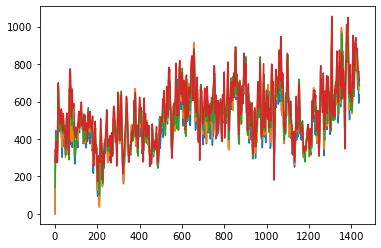

In [3]:
heights = {"48": 61, "49": 85, "50": 107, "51": 128}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()

# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}

for key in heights.keys():
    ls = glob("WEATHER_*%s_May*" % key)
    
    data = np.genfromtxt(ls[0], skip_header=5, delimiter=',')

    # Convert from km/hr to cm/s
    windspeeds[key] = data[:,7]*27.7778

    print(np.mean(data[:, 7]))
    
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    
    plt.plot(time, data[:, 7]*27.7778)


(array([ 5.,  8., 29., 43., 45., 69., 86., 83., 81., 69., 65., 43., 36.,
        26., 13.,  9.,  5.,  2.,  3.]),
 array([ 175.00014   ,  221.34520632,  267.69027263,  314.03533895,
         360.38040526,  406.72547158,  453.07053789,  499.41560421,
         545.76067053,  592.10573684,  638.45080316,  684.79586947,
         731.14093579,  777.48600211,  823.83106842,  870.17613474,
         916.52120105,  962.86626737, 1009.21133368, 1055.5564    ]),
 <BarContainer object of 19 artists>)

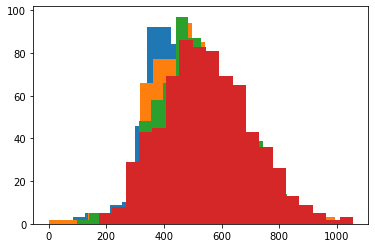

In [77]:
plt.hist(windspeeds["48"], bins='auto')
plt.hist(windspeeds["49"], bins='auto')
plt.hist(windspeeds["50"], bins='auto')
plt.hist(windspeeds["51"], bins='auto')

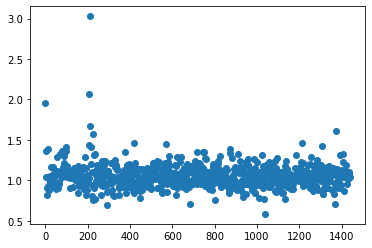

In [65]:
plt.scatter(time, windspeeds["51"]/windspeeds["50"])

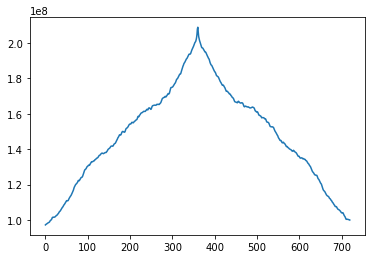

In [15]:
ret = np.correlate(windspeeds["48"], windspeeds["51"], "same")
plt.plot(ret)

In [79]:
def lin_fit(x, m, b):
    return m*x + b

# First fit the total time-averaged wind profile
averaged_windspeeds = np.array([])
averaged_heights = np.array([])
std_windspeeds = np.array([])
for key in heights.keys():
    averaged_heights = np.append(heights[key], averaged_heights)
    averaged_windspeeds = np.append(np.mean(windspeeds[key]), averaged_windspeeds)
    std_windspeeds = np.append(np.std(windspeeds[key])/(np.sqrt(len(windspeeds[key])) - 1), std_windspeeds)
    
saved_zstar = calculate_zstar_from_profile(averaged_heights, averaged_windspeeds)
print(saved_zstar)
saved_averaged_heights = averaged_heights
saved_averaged_windspeeds = averaged_windspeeds

0.09076297427554655


9.344738931222305e-14


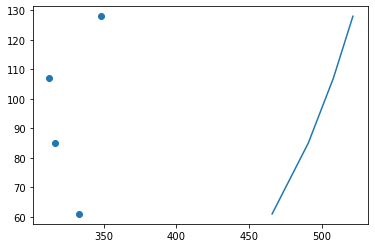

In [86]:
def sample_wind_profile(sample_time, t0, time=time, windspeeds=windspeeds):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        time (float array, optional): measured times
        windspeeds (dict of float arrays, optional): wind speed time-series referenced by anemometer name
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_heights = np.array([])
    averaged_windspeeds = np.array([])
    std_windspeeds = np.array([])
    for key in windspeeds.keys():
        ind = (time - cur_t0) <= sample_time
        
        averaged_windspeeds = np.append(np.mean(windspeeds[key][ind]), averaged_windspeeds)
        averaged_heights = np.append(heights[key], averaged_heights)
        std_windspeeds = np.append(np.std(windspeeds[key][ind])/(np.sqrt(len(windspeeds[key][ind])) - 1.),
                                   std_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_heights, averaged_windspeeds, std_windspeeds
    
averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(0., 15.)
# plt.errorbar(averaged_windspeeds, averaged_heights, xerr=std_windspeeds)
plt.scatter(averaged_windspeeds, averaged_heights)

# x = np.log(averaged_heights/np.min(averaged_heights))
# y = averaged_windspeeds
# sigma = std_windspeeds
# popt, pcov = curve_fit(lin_fit, x, y)
# unc = np.sqrt(np.diag(pcov))

zstar = calculate_zstar_from_profile(averaged_heights, averaged_windspeeds)
print(zstar)
# print(calc_zstar_from_slope_and_intercept(np.min(averaged_heights), *popt))
ustar = calc_ustar_from_slope(0.4, popt[0])
sigma_ustar = calc_sigma_ustar(0.4, unc[0])
# print(ustar, sigma_ustar)

# def calc_sigma_zstar(kappa, ustar, sigma_ustar, zstar, intercept, sigma_intercept):

plt.plot(lin_fit(x, *popt), averaged_heights)

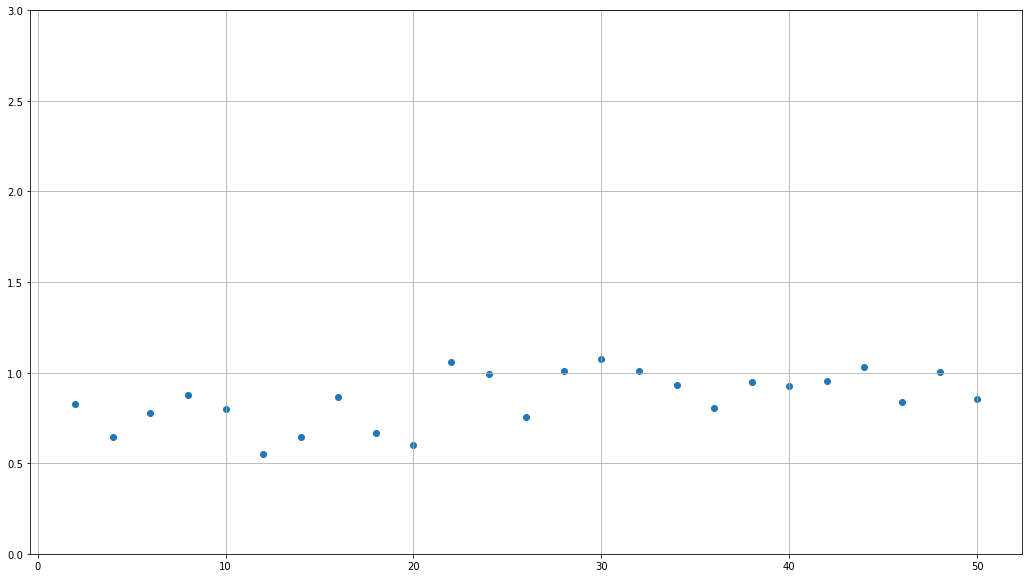

In [96]:

fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
# sample_times = 2.**(np.linspace(1, 8, 8))
sample_times = np.arange(2, 52, 2)
# sample_times = np.array([1000])
# print(sample_times)
num_tries = 100

saved_sample_times = np.array([])
zstars = np.array([])
zstars_sigma = np.array([])

for i in range(len(sample_times)):
    cur_saved_sample_times = np.array([])
    cur_zstars = np.array([])
    
    for j in range(num_tries):
        
        # Make sure there is plenty of time at the end
        t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
#         t0 = 0.
        averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
                
        cur_zstars = np.append(calculate_zstar_from_profile(averaged_heights, averaged_windspeeds), cur_zstars)
        cur_saved_sample_times = np.append(sample_times[i], cur_saved_sample_times)
        
    zstars = np.append(np.mean(cur_zstars), zstars)
    zstars_sigma = np.append(np.std(cur_zstars), zstars_sigma)
    saved_sample_times = np.append(sample_times[i], saved_sample_times)
   
# ax.errorbar(saved_sample_times, zstars, zstars_sigma, marker='.')
ax.scatter(saved_sample_times, (zstars - saved_zstar)/zstars_sigma)
# print(saved_sample_times)
# print(zstars)
# ax.axhline(saved_zstar)
ax.set_ylim([0, 3])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.grid(True)

# averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(10., 1000.)
# 470.0 2.775384704365744
# 78.0 5.040332891552976e-07

50.205000196761546
58.92751627777773
0.1682524263213198


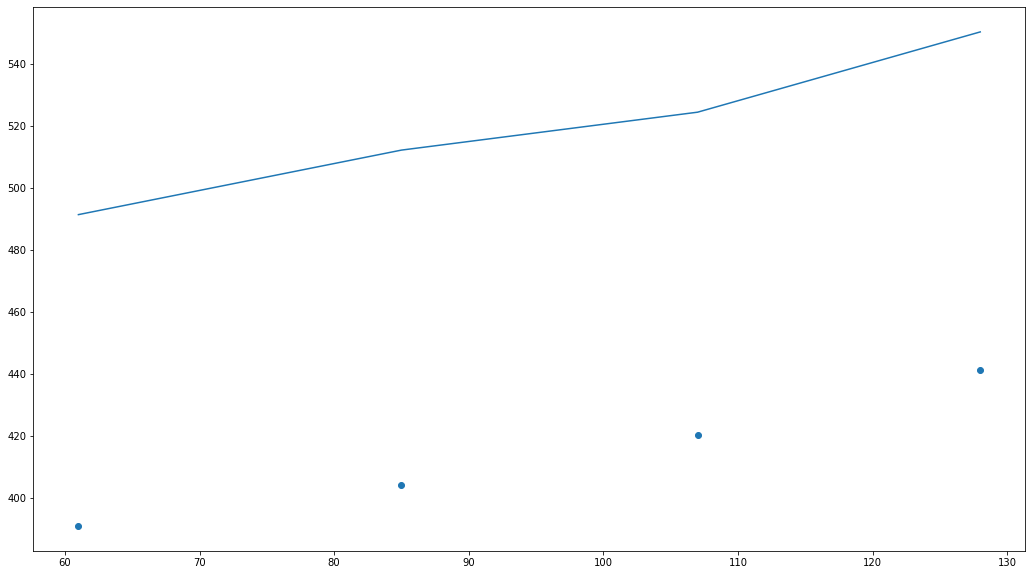

In [336]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
sample_times = [5.]
# print(sample_times)
num_tries = 1

saved_sample_times = np.array([])
zstars = np.array([])

for i in range(len(sample_times)):
    for j in range(num_tries):
        
        # Make sure there is plenty of time at the end
        t0 = 470.
        averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
        
        plt.scatter(averaged_heights, averaged_windspeeds)
        plt.plot(saved_averaged_heights, saved_averaged_windspeeds)
        
        print(np.max(averaged_windspeeds) - np.min(averaged_windspeeds))
        print(np.max(saved_averaged_windspeeds) - np.min(saved_averaged_windspeeds))
        
        print(calculate_zstar_from_profile(averaged_heights, averaged_windspeeds))

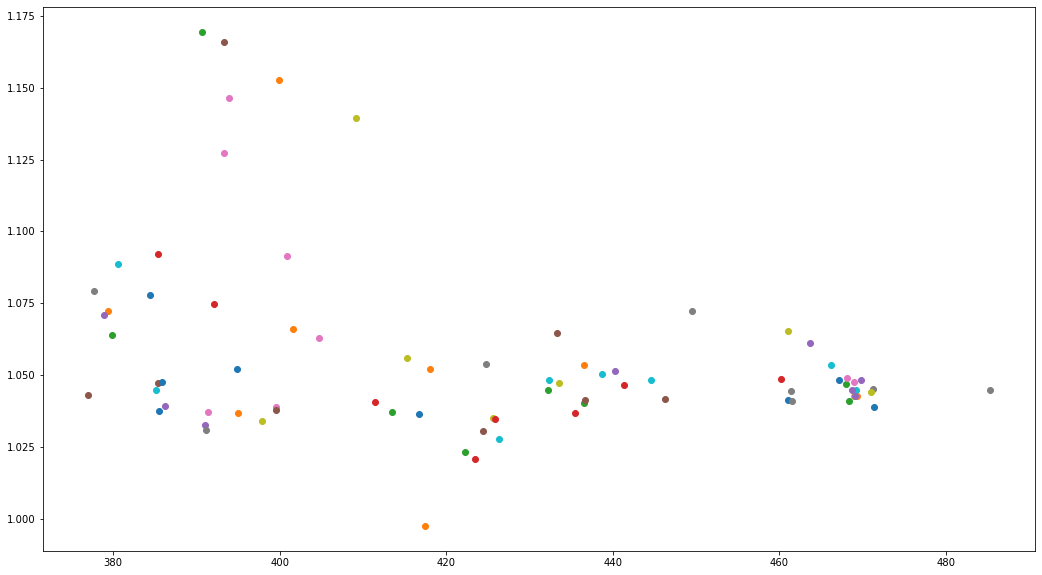

In [300]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
sample_times = 2.**(np.linspace(1, 8, 8))
num_tries = 10

saved_sample_times = np.array([])
zstars = np.array([])

for i in range(len(sample_times)):
    for j in range(num_tries):
        
        # Make sure there is plenty of time at the end
        t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
        averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
        
        plt.plot(averaged_windspeeds[-1], averaged_windspeeds[2]/averaged_windspeeds[-1],
                 ls='', marker='o')